# TEST DIFFERENT APPROXIMATIONS FOR KL(logit)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy
from genus.util_ml import Grid_DPP
from genus.util_vis import show_batch
import torch.nn.functional as F

def bernoulli_entropy(logit):
    p = torch.sigmoid(logit)
    one_m_p = torch.sigmoid(-logit)
    log_p = F.logsigmoid(logit)
    log_one_m_p = F.logsigmoid(-logit)
    entropy = - (p * log_p + one_m_p * log_one_m_p)
    return entropy

def logp_bernoulli(c, logit):
    log_p = F.logsigmoid(logit)
    log_one_m_p = F.logsigmoid(-logit)
    log_prob_bernoulli = (c.detach() * log_p + ~c.detach() * log_one_m_p)
    return log_prob_bernoulli

def all_configurations(grid_size_x, grid_size_y):
    all_c = torch.zeros(2**(grid_size_x*grid_size_y),grid_size_x,grid_size_y).flatten(start_dim=1).numpy()
    for n in range(2**(grid_size_x*grid_size_y)):
        tmp = bin(n).lstrip("0b").rjust(grid_size_x*grid_size_y, "0")
        all_c[n] =  numpy.array(list(tmp), dtype=int)
    all_c = torch.from_numpy(all_c).view(-1, grid_size_x,grid_size_y).bool()
    return all_c

# TRAINING

In [32]:
grid_size_x, grid_size_y = 3, 3
c_all = all_configurations(grid_size_x, grid_size_y).detach()

DPP_0 = Grid_DPP(length_scale=10, weight=0.01)
DPP_1 = Grid_DPP(length_scale=10, weight=0.01)
DPP_2 = Grid_DPP(length_scale=10, weight=0.01)
DPP_3 = Grid_DPP(length_scale=10, weight=0.01)
DPP_4 = Grid_DPP(length_scale=10, weight=0.01)


logit_0 = torch.rand((grid_size_x,grid_size_y)).requires_grad_(False)
logit_1 = logit_0.clone().requires_grad_(True)
logit_2 = logit_0.clone().requires_grad_(True)
logit_3 = logit_0.clone().requires_grad_(True)
logit_4 = logit_0.clone().requires_grad_(True)

params1 = [logit_1]
for name, param in DPP_1.named_parameters():
    params1.append(param)
    
optimizer1 = torch.optim.SGD([{'params': params1, 'lr': 1E-2}])


params2 = [logit_2]
for name, param in DPP_2.named_parameters():
    params2.append(param)
    
optimizer2 = torch.optim.SGD([{'params': params2, 'lr': 1E-2}])


params3 = [logit_3]
for name, param in DPP_3.named_parameters():
    params3.append(param)
    
optimizer3 = torch.optim.SGD([{'params': params3, 'lr': 1E-2}])


params4 = [logit_4]
for name, param in DPP_4.named_parameters():
    params4.append(param)
    
optimizer4 = torch.optim.SGD([{'params': params4, 'lr': 1E-2}])

In [33]:
mc_samples = 40
mse = 10.0

for epoch in range(10000):
    
    # Exact
    prob_1 = F.sigmoid(logit_1)
    c_before_nms = (torch.rand_like(logit_1) < prob_1)
    score = c_before_nms + prob_1
    c_after_nms = (score == torch.max(score)) * c_before_nms
    
    entropy_1 = bernoulli_entropy(logit_1).sum()
    logp_c_all = DPP_1.log_prob(c_all).detach()
    q_c_all = logp_bernoulli(c_all, logit_1).sum(dim=(-1,-2)).exp()
    logp_dpp_after = DPP_1.log_prob(c_after_nms).mean()
    
    loss1 = -entropy_1 - logp_dpp_after -(q_c_all * logp_c_all).sum() - mse * F.sigmoid(logit_1[0,0])
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step() 
    
    # reinforce
    prob_2 = F.sigmoid(logit_2)
    c_before_nms = (torch.rand_like(logit_2.expand(mc_samples,-1,-1)) < prob_2)
    score = c_before_nms + prob_2
    c_after_nms = (score == torch.max(score)) * c_before_nms
    
    entropy_2 = bernoulli_entropy(logit_2).sum()
    logp_dpp_before = DPP_2.log_prob(c_before_nms)
    logp_dpp_after = DPP_2.log_prob(c_after_nms)
    logp_ber_before = logp_bernoulli(c_before_nms, logit_2).sum(dim=(-1,-2))
    d_tmp = (logp_dpp_before - logp_dpp_before.mean()).abs().mean().detach()
    reinforce_2 = logp_ber_before * (logp_dpp_before - logp_dpp_before.mean()).detach()
    
    loss2 = - entropy_2 - logp_dpp_after.mean() - reinforce_2.mean() - mse * F.sigmoid(logit_2[0,0])
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step() 
    
    
    # reinforce + importance sampling
    prob_3 = F.sigmoid(logit_3)
    c_before_nms = (torch.rand_like(logit_3) < prob_3)
    score = c_before_nms + prob_3
    c_after_nms = (score == torch.max(score)) * c_before_nms
    
    logit_importance = logit_3.clamp(min=-3.5, max=3.5).detach()
    prob_importance = F.sigmoid(logit_importance)
    c_importance = (torch.rand_like(logit_importance.expand(mc_samples,-1,-1)) < prob_importance)
    
    entropy_3 = bernoulli_entropy(logit_3).sum()
    logp_dpp_after = DPP_3.log_prob(c_after_nms)
    logp_importance = DPP_3.log_prob(c_importance)
    logq_importance_star = logp_bernoulli(c_importance, logit_3).sum(dim=(-1,-2))
    logq_importance = logp_bernoulli(c_importance, logit_importance.detach()).sum(dim=(-1,-2))
    importance_weights = (logq_importance_star - logq_importance).exp().detach()
    reinforce_3 = logq_importance_star * (importance_weights*logp_importance - (importance_weights*logp_importance).mean()).detach()
        
    loss3 = - entropy_3 - logp_dpp_after.mean() - reinforce_3.mean() - mse * F.sigmoid(logit_3[0,0])
    optimizer3.zero_grad()
    loss3.backward()
    optimizer3.step() 

    
    if epoch % 500 == 0:
        print(epoch,entropy_1.item(),entropy_2.item(),entropy_3.item(),d_tmp,importance_weights.mean())
    

0 5.885968208312988 5.885968208312988 5.885968208312988 tensor(9.7843) tensor(1.)
500 2.4772024154663086 2.3309171199798584 2.514336585998535 tensor(3.0775) tensor(1.)
1000 1.7957062721252441 1.711425542831421 1.8127392530441284 tensor(2.1557) tensor(1.0061)
1500 1.511854648590088 1.4836840629577637 1.5499870777130127 tensor(0.6471) tensor(1.0018)
2000 1.356196403503418 1.3666213750839233 1.4226170778274536 tensor(1.3280) tensor(1.0046)
2500 1.2611382007598877 1.2742401361465454 1.3372982740402222 tensor(0.9973) tensor(1.0220)
3000 1.1949589252471924 1.213947057723999 1.2751801013946533 tensor(2.0766) tensor(0.9931)
3500 1.145513892173767 1.1792360544204712 1.2418241500854492 tensor(1.4799) tensor(1.0113)
4000 1.1069021224975586 1.1402809619903564 1.2057081460952759 tensor(1.7377) tensor(0.9732)
4500 1.0761446952819824 1.1057825088500977 1.1864125728607178 tensor(1.4616) tensor(0.9557)
5000 1.0500636100769043 1.0748745203018188 1.1721515655517578 tensor(1.6638) tensor(0.9981)
5500 1.02

In [34]:
print("INITIAL PROB")
print("nav ->",F.sigmoid(logit_0).sum().item())
print(F.sigmoid(logit_0))

print("FINAL PROB_1")
print("nav ->",F.sigmoid(logit_1).sum().item())
print(F.sigmoid(logit_1))

print("FINAL PROB_2")
print("nav ->",F.sigmoid(logit_2).sum().item())
print(F.sigmoid(logit_2))

print("FINAL PROB_3")
print("nav ->",F.sigmoid(logit_3).sum().item())
print(F.sigmoid(logit_3))

# print("FINAL PROB_4")
# print("nav ->",F.sigmoid(logit_4).sum().item())
# print(F.sigmoid(logit_4))
# 
# print("FINAL DPP_1")
# print(DPP_1.fingerprint[:2])
# final_dpp_sample_1 = DPP_1.sample(size=logit_1.expand(10000,-1,-1).size())
# nav_final_1 = final_dpp_sample_1.sum(dim=(-1,-2)).float().mean()
# print("nav ->",nav_final_1)
# print(final_dpp_sample_1.float().mean(dim=0))
# 
# print("FINAL DPP_2")
# print(DPP_2.fingerprint[:2])
# final_dpp_sample_2 = DPP_2.sample(size=logit_2.expand(10000,-1,-1).size())
# nav_final_2 = final_dpp_sample_2.sum(dim=(-1,-2)).float().mean()
# print("nav ->",nav_final_2)
# print(final_dpp_sample_2.float().mean(dim=0))
# 
# print("FINAL DPP_3")
# print(DPP_3.fingerprint[:2])
# final_dpp_sample_3 = DPP_3.sample(size=logit_3.expand(10000,-1,-1).size())
# nav_final_3 = final_dpp_sample_3.sum(dim=(-1,-2)).float().mean()
# print("nav ->",nav_final_3)
# print(final_dpp_sample_3.float().mean(dim=0))
# 
# print("FINAL DPP_4")
# print(DPP_4.fingerprint[:2])
# final_dpp_sample_4 = DPP_4.sample(size=logit_4.expand(10000,-1,-1).size())
# nav_final_4 = final_dpp_sample_4.sum(dim=(-1,-2)).float().mean()
# print("nav ->",nav_final_4)
# print(final_dpp_sample_4.float().mean(dim=0))

INITIAL PROB
nav -> 5.529770374298096
tensor([[0.7031, 0.5075, 0.5464],
        [0.7189, 0.7015, 0.5459],
        [0.5382, 0.6269, 0.6414]])
FINAL PROB_1
nav -> 1.1980738639831543
tensor([[0.9975, 0.0103, 0.0282],
        [0.0104, 0.0141, 0.0313],
        [0.0282, 0.0313, 0.0469]], grad_fn=<SigmoidBackward>)
FINAL PROB_2
nav -> 1.2089787721633911
tensor([[0.9974, 0.0112, 0.0286],
        [0.0103, 0.0157, 0.0312],
        [0.0293, 0.0344, 0.0509]], grad_fn=<SigmoidBackward>)
FINAL PROB_3
nav -> 1.2241153717041016
tensor([[0.9883, 0.0215, 0.0281],
        [0.0217, 0.0250, 0.0298],
        [0.0298, 0.0319, 0.0479]], grad_fn=<SigmoidBackward>)


In [37]:
a = torch.zeros(3,12,3,3)
b = torch.split(a, split_size_or_sections=[], dim=-3)

(tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]]),
 tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]]),
 tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]]),
 tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]]),
 tensor([[[[0., 0., 0.],
           

In [27]:
print(logit_1)
print(logit_2)
print(logit_3)

tensor([[ 5.9691, -4.5568, -3.5381],
        [-4.5598, -4.2485, -3.4295],
        [-3.5352, -3.4310, -3.0103]], requires_grad=True)
tensor([[ 5.9356, -3.7393, -2.9065],
        [-3.8066, -3.9717, -2.8483],
        [-2.7721, -2.6701, -2.4147]], requires_grad=True)
tensor([[ 4.4498, -3.7165, -2.8374],
        [-3.5242, -3.3233, -2.7838],
        [-2.8806, -2.7561, -2.6839]], requires_grad=True)


In [29]:
print(logit_1.grad)
print(logit_2.grad)
print(logit_3.grad)

tensor([[-0.0087,  0.0048,  0.0019],
        [ 0.0047,  0.0037,  0.0017],
        [ 0.0020,  0.0017,  0.0013]])
tensor([[-0.0107, -0.0848, -0.1427],
        [-0.0809, -0.0721,  0.2563],
        [-0.1534,  0.2421, -0.1817]])
tensor([[-0.0634, -0.0861, -0.1482],
        [-0.0980, -0.1115, -0.1525],
        [-0.1448, -0.1547,  0.3806]])


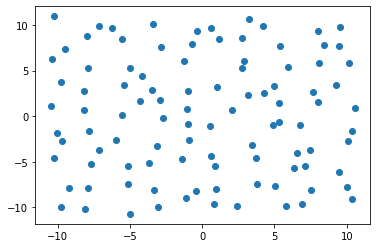

In [57]:
x_clean = torch.linspace(-10,10,10)
y_clean = torch.linspace(-10,10,10)
grid_x, grid_y = torch.meshgrid(x_clean, y_clean)
grid_x = grid_x + 0.5*torch.randn_like(grid_x)
grid_y = grid_y + 0.5*torch.randn_like(grid_y)

plt.scatter(grid_x.reshape(-1),grid_y.reshape(-1))

In [81]:
sigma = 10  # width of the gaussian blob
spacing = 0.3  # pixel_size
d = int(3*sigma/spacing)  # number of pixel away from gaussian center 
padding = 3*sigma  # padding of image    
x_min = torch.min(grid_x) - padding
x_max = torch.max(grid_x) + padding
y_min = torch.min(grid_y) - padding
y_max = torch.max(grid_y) + padding
nx = numpy.ceil((x_max - x_min)/spacing).int().item()  # width in pixel of the image
ny = numpy.ceil((y_max - y_min)/spacing).int().item()  # height in pixel of the image

In [86]:
image = torch.zeros((nx,ny))
x_list = grid_x.reshape(-1)
y_list = grid_y.reshape(-1)

# loop over points sources
for x,y in zip(x_list, y_list):
    # coordinates of the points
    xc = x.item()
    yc = y.item()
    
    # location in the image
    ix = ((xc - x_min)/spacing).int().item()
    iy = ((yc - y_min)/spacing).int().item()
    print(xc,yc)
    print(ix,iy)
    
    # loop over pixels affected by that source (a small square of size 3 sigma around the beads location)
    for i in range(-d,d+1):
        for j in range(-d,d+1):
            d2 = (ix+i-xc)**2 + (iy+j-yc)**2
            image[ix+i,iy+j] += torch.exp(-d2)
 
    assert 1==2



-9.762372970581055 -9.93736457824707
102 102
28.085409097304364
30.572882012953777
33.26035492860319
36.1478278442526
39.23530075990202
42.522773675551434
46.01024659120085
49.69771950685026
53.585192422499674
57.67266533814909
61.960138253798505
66.44761116944792
71.13508408509733
76.02255700074674
81.11002991639616
86.39750283204557
91.884975747695
97.5724486633444
103.45992157899381
109.54739449464323
115.83486741029265
122.32234032594206
129.00981324159147
135.8972861572409
142.9847590728903
150.27223198853972
157.75970490418914
165.44717781983854
173.33465073548797
181.42212365113738
189.7095965667868
198.1970694824362
206.8845423980856
215.77201531373504
224.85948822938445
234.14696114503386
243.63443406068328
253.32190697633268
263.2093798919821
273.2968528076315
283.5843257232809
294.0717986389303
304.75927155457975
315.6467444702292
326.7342173858786
338.021690301528
349.5091632171774
361.1966361328268
373.08410904847625
385.17158196412566
397.45905487977507
409.94652779542446

55.792678765883466
58.48015168153288
61.36762459718229
64.45509751283171
67.74257042848112
71.23004334413054
74.91751625977994
78.80498917542937
82.89246209107878
87.17993500672819
91.6674079223776
96.35488083802701
101.24235375367644
106.32982666932585
111.61729958497526
117.10477250062468
122.79224541627408
128.6797183319235
134.76719124757292
141.05466416322233
147.54213707887175
154.22960999452116
161.11708291017058
168.20455582582
175.4920287414694
182.97950165711882
190.66697457276823
198.55444748841765
206.64192040406706
214.92939331971647
223.4168662353659
232.1043391510153
240.99181206666472
250.07928498231414
259.36675789796357
268.85423081361296
278.5417037292624
288.42917664491176
298.5166495605612
308.80412247621064
319.29159539186
329.97906830750946
340.86654122315883
351.95401413880825
363.2414870544577
374.7289599701071
386.41643288575654
398.3039058014059
410.3913787170553
422.6788516327048
435.16632454835417
447.8537974640036
460.741270379653
473.8287432953024
487.116

1193.8949820800924
1215.1824549957419
1236.6699279113914
1258.3574008270407
1280.24487374269
1302.3323466583395
1324.619819573989
1347.1072924896384
1369.7947654052878
1392.6822383209371
1415.7697112365865
1439.057184152236
1462.5446570678855
1486.2321299835348
1510.1196028991842
1534.2070758148336
1558.494548730483
1582.9820216461326
1607.669494561782
1632.5569674774313
1657.6444403930807
1682.9319133087301
1708.4193862243797
1734.106859140029
1759.9943320556783
1786.0818049713278
1812.3692778869772
1838.8567508026267
1865.544223718276
1892.4316966339254
1919.5191695495748
1946.8066424652243
1974.2941153808738
2001.9815882965231
2029.8690612121725
2057.956534127822
2086.2440070434714
2114.731479959121
2143.41895287477
2172.30642579042
2201.393898706069
2230.6813716217184
2260.168844537368
2289.8563174530173
2319.743790368667
2349.8312632843163
2380.1187361999655
2410.606209115615
2441.2936820312643
2472.181154946914
2503.2686278625633
2534.5561007782126
2566.043573693862
2597.73104660

4031.909812478653
4071.597285394301
4111.484758309952
4151.572231225599
4191.85970414125
4232.347177056899
4273.034649972547
4313.922122888197
4355.009595803846
4396.2970687194975
4437.7845416351465
4479.4720145507945
4521.359487466444
4563.4469603820935
4605.734433297743
135.0923247619772
137.57979767762663
140.26727059327604
143.15474350892546
146.24221642457488
149.52968934022428
153.0171622558737
156.7046351715231
160.59210808717253
164.67958100282195
168.96705391847135
173.45452683412077
178.14199974977018
183.0294726654196
188.11694558106902
193.40441849671842
198.89189141236784
204.57936432801725
210.46683724366667
216.5543101593161
222.8417830749655
229.3292559906149
236.01672890626432
242.90420182191374
249.99167473756316
257.2791476532126
264.766620568862
272.4540934845114
280.3415664001608
288.4290393158102
296.71651223145966
305.20398514710905
313.8914580627585
322.77893097840786
331.86640389405727
341.15387680970673
350.6413497253561
360.32882264100556
370.2162955566549
38

983.282534341445
1001.3700072570944
1019.6574801727438
1038.1449530883933
1056.8324260040426
1075.719898919692
1094.8073718353414
1114.094844750991
1133.5823176666404
1153.2697905822897
1173.157263497939
1193.2447364135885
1213.532209329238
1234.0196822448875
1254.7071551605368
1275.5946280761862
1296.6821009918356
1317.969573907485
1339.4570468231345
1361.1445197387839
1383.0319926544332
1405.1194655700826
1427.406938485732
1449.8944114013816
1472.581884317031
1495.4693572326803
1518.5568301483297
1541.8443030639792
1565.3317759796287
1589.019248895278
1612.9067218109274
1636.9941947265768
1661.2816676422262
1685.7691405578757
1710.456613473525
1735.3440863891744
1760.4315593048238
1785.7190322204733
1811.2065051361228
1836.8939780517721
1862.7814509674215
1888.868923883071
1915.1563967987204
1941.6438697143699
1968.3313426300192
1995.2188155456686
2022.306288461318
2049.5937613769674
2077.081234292617
2104.7687072082663
2132.656180123916
2160.7436530395653
2189.0311259552145
2217.518

3547.897364740004
3584.3848376556534
3621.0723105713028
3657.959783486952
3695.0472564026013
3732.334729318251
3769.822202233902
3807.50967514955
3845.397148065199
3883.4846209808484
3921.772093896498
3960.2595668121476
3998.9470397277983
4037.834512643446
4076.9219855590973
4116.209458474745
4155.696931390396
4195.3844043060435
4235.271877221695
4275.3593501373425
4315.646823052994
4356.134295968643
4396.821768884291
4437.70924179994
4478.79671471559
4520.084187631241
4561.57166054689
4603.259133462538
4645.146606378187
4687.234079293837
4729.521552209486
261.8794436737204
264.3669165893698
267.05438950501923
269.9418624206686
273.029335336318
276.3168082519675
279.80428116761686
283.4917540832663
287.37922699891567
291.4666999145651
295.75417283021454
300.24164574586393
304.92911866151337
309.81659157716274
314.90406449281215
320.1915374084616
325.679010324111
331.36648323976044
337.2539561554098
343.3414290710592
349.6289019867087
356.1163749023581
362.8038478180075
369.691320733656

353.0741862579489
355.9616591735983
359.04913208924773
362.33660500489714
365.82407792054653
369.51155083619597
373.3990237518454
377.4864966674948
381.7739695831442
386.2614424987936
390.94891541444304
395.83638833009246
400.9238612457419
406.2113341613913
411.69880707704067
417.3862799926901
423.27375290833953
429.36122582398895
435.64869873963835
442.13617165528774
448.8236445709372
455.7111174865866
462.798590402236
470.0860633178854
477.5735362335348
485.26100914918425
493.1484820648337
501.2359549804831
509.5234278961325
518.0109008117819
526.6983737274313
535.5858466430807
544.6733195587301
553.9607924743796
563.448265390029
573.1357383056784
583.0232112213278
593.1106841369772
603.3981570526266
613.885629968276
624.5731028839255
635.4605757995748
646.5480487152242
657.8355216308737
669.3229945465231
681.0104674621725
692.8979403778219
704.9854132934713
717.2728862091208
729.7603591247702
742.4478320404196
755.335304956069
768.4227778717184
781.7102507873678
795.1977237030172
80

3160.084917001357
3193.3723899170063
3226.859862832656
3260.547335748305
3294.4348086639548
3328.522281579604
3362.8097544952534
3397.297227410903
3431.9847003265522
3466.872173242202
3501.9596461578512
3537.2471190735005
3572.73459198915
3608.4220649047993
3644.309537820449
3680.3970107360983
3716.684483651747
3753.1719565673966
3789.859429483046
3826.746902398695
3863.8343753143445
3901.121848229994
3938.609321145645
3976.296794061293
4014.184266976942
4052.2717398925915
4090.559212808241
4129.046685723891
4167.734158639541
4206.621631555189
4245.70910447084
4284.996577386488
4324.484050302139
4364.171523217787
4404.058996133438
4444.146469049086
4484.433941964737
4524.921414880386
4565.608887796034
4606.496360711683
4647.583833627333
4688.871306542984
4730.358779458633
4772.046252374281
4813.93372528993
4856.02119820558
4898.308671121229
433.66656258546357
436.15403550111296
438.8415084167624
441.72898133241176
444.8164542480612
448.10392716371064
451.59140007936
455.27887299500946


1108.154622583022
1123.8420954986716
1139.729568414321
1155.8170413299704
1172.1045142456198
1188.5919871612691
1205.2794600769187
1222.166932992568
1239.2544059082174
1256.541878823867
1274.0293517395162
1291.7168246551657
1309.604297570815
1327.6917704864645
1345.979243402114
1364.4667163177633
1383.1541892334128
1402.0416621490622
1421.1291350647116
1440.416607980361
1459.9040808960103
1479.5915538116599
1499.4790267273092
1519.5664996429587
1539.8539725586081
1560.3414454742574
1581.028918389907
1601.9163913055563
1623.0038642212057
1644.2913371368552
1665.7788100525045
1687.466282968154
1709.3537558838034
1731.4412287994528
1753.7287017151023
1776.2161746307515
1798.903647546401
1821.7911204620505
1844.8785933776999
1868.1660662933493
1891.6535392089986
1915.3410121246482
1939.2284850402975
1963.315957955947
1987.6034308715964
2012.0909037872457
2036.7783767028952
2061.6658496185446
2086.753322534194
2112.0407954498432
2137.5282683654927
2163.215741281142
2189.1032141967917
2215.1

2195.7381667419577
2221.425639657607
2247.3131125732566
2273.400585488906
2299.6880584045552
2326.1755313202048
2352.863004235854
2379.7504771515037
2406.837950067153
2434.1254229828023
2461.612895898452
2489.300368814101
2517.1878417297507
2545.2753146454
2573.5627875610494
2602.050260476699
2630.737733392348
2659.625206307998
2688.7126792236472
2718.0001521392965
2747.487625054946
2777.1750979705953
2807.062570886245
2837.1500438018943
2867.4375167175435
2897.924989633193
2928.6124625488424
2959.499935464492
2990.5874083801414
3021.8748812957906
3053.36235421144
3085.0498271270894
3116.937300042739
3149.0247729583884
3181.3122458740377
3213.799718789687
3246.4871917053365
3279.374664620986
3312.4621375366355
3345.7496104522847
3379.2370833679342
3412.9245562835836
3446.812029199233
3480.8995021148826
3515.186975030532
3549.6744479461813
3584.3619208618306
3619.2493937774802
3654.3368666931297
3689.624339608779
3725.1118125244284
3760.7992854400777
3796.6867583557273
3832.774231271376

2324.5754855438377
2350.662958459487
2376.9504313751363
2403.437904290786
2430.125377206435
2457.0128501220847
2484.100323037734
2511.3877959533834
2538.875268869033
2566.562741784682
2594.450214700332
2622.537687615981
2650.8251605316304
2679.31263344728
2708.0001063629293
2736.887579278579
2765.9750521942283
2795.2625251098775
2824.749998025527
2854.4374709411763
2884.324943856826
2914.4124167724754
2944.6998896881246
2975.187362603774
3005.8748355194234
3036.762308435073
3067.8497813507224
3099.1372542663717
3130.624727182021
3162.3122000976705
3194.19967301332
3226.2871459289695
3258.5746188446187
3291.0620917602682
3323.7495646759176
3356.637037591567
3389.7245105072166
3423.011983422866
3456.4994563385153
3490.1869292541646
3524.074402169814
3558.1618750854636
3592.449348001113
3626.9368209167624
3661.6242938324117
3696.5117667480613
3731.5992396637107
3766.88671257936
3802.3741854950094
3838.0616584106588
3873.9491313263084
3910.036604241958
3946.3240771576066
3982.8115500732556

4381.226180963148
4419.513653878797
4458.001126794447
4496.688599710098
4535.576072625746
4574.663545541397
4613.9510184570445
4653.438491372695
4693.125964288343
4733.013437203995
4773.100910119642
4813.388383035293
4853.875855950942
4894.56332886659
4935.45080178224
4976.538274697889
5017.82574761354
5059.3132205291895
5101.000693444837
5142.888166360487
5184.9756392761365
5227.263112191786
767.0210036560202
769.5084765716696
772.195949487319
775.0834224029684
778.1708953186178
781.4583682342673
784.9458411499166
788.6333140655661
792.5207869812155
796.6082598968649
800.8957328125143
805.3832057281637
810.0706786438132
814.9581515594625
820.0456244751119
825.3330973907614
830.8205703064108
836.5080432220602
842.3955161377096
848.482989053359
854.7704619690085
861.2579348846579
867.9454078003073
874.8328807159567
881.9203536316061
889.2078265472555
896.6952994629049
904.3827723785544
912.2702452942037
920.3577182098531
928.6451911255026
937.132664041152
945.8201369568014
954.707609872

2673.060021524062
2699.9474944397116
2727.034967355361
2754.3224402710102
2781.8099131866597
2809.497386102309
2837.3848590179587
2865.472331933608
2893.7598048492573
2922.247277764907
2950.934750680556
2979.8222235962057
3008.909696511855
3038.1971694275044
3067.684642343154
3097.372115258803
3127.259588174453
3157.347061090102
3187.6345340057514
3218.122006921401
3248.8094798370503
3279.6969527527
3310.7844256683493
3342.0718985839985
3373.559371499648
3405.2468444152973
3437.134317330947
3469.2217902465964
3501.5092631622456
3533.996736077895
3566.6842089935444
3599.571681909194
3632.6591548248434
3665.9466277404927
3699.434100656142
3733.1215735717915
3767.009046487441
3801.0965194030905
3835.3839923187397
3869.8714652343892
3904.5589381500386
3939.446411065688
3974.5338839813376
4009.821356896987
4045.3088298126363
4080.9963027282856
4116.883775643935
4152.971248559585
4189.258721475233
4225.746194390883
4262.433667306532
4299.321140222181
4336.408613137831
4373.69608605348
4411.1

1235.6172000213767
1245.104672937026
1254.7921458526755
1264.6796187683249
1274.7670916839743
1285.0545645996237
1295.542037515273
1306.2295104309226
1317.116983346572
1328.2044562622214
1339.4919291778708
1350.97940209352
1362.6668750091696
1374.554347924819
1386.6418208404684
1398.9292937561179
1411.4167666717672
1424.1042395874167
1436.991712503066
1450.0791854187155
1463.366658334365
1476.8541312500142
1490.5416041656638
1504.4290770813132
1518.5165499969626
1532.804022912612
1547.2914958282613
1561.9789687439109
1576.8664416595602
1591.9539145752096
1607.241387490859
1622.7288604065084
1638.416333322158
1654.3038062378073
1670.3912791534567
1686.6787520691062
1703.1662249847554
1719.853697900405
1736.7411708160544
1753.8286437317038
1771.1161166473532
1788.6035895630025
1806.291062478652
1824.1785353943014
1842.2660083099508
1860.5534812256003
1879.0409541412496
1897.7284270568991
1916.6158999725485
1935.703372888198
1954.9908458038474
1974.4783187194967
1994.1657916351462
2014.05

3366.6892833038473
3396.7767562194967
3427.064229135146
3457.5517020507955
3488.239174966445
3519.1266478820944
3550.214120797744
3581.501593713393
3612.9890666290426
3644.676539544692
3676.5640124603415
3708.651485375991
3740.93895829164
3773.4264312072896
3806.113904122939
3839.0013770385885
3872.088849954238
3905.376322869887
3938.8637957855367
3972.551268701186
4006.4387416168356
4040.526214532485
4074.8136874481343
4109.301160363784
4143.988633279433
4178.876106195083
4213.963579110732
4249.251052026381
4284.738524942031
4320.42599785768
4356.31347077333
4392.400943688979
4428.6884166046275
4465.175889520277
4501.863362435926
4538.750835351576
4575.838308267225
4613.125781182875
4650.613254098525
4688.300727014173
4726.188199929823
4764.275672845472
4802.563145761122
4841.050618676772
4879.738091592422
4918.62556450807
4957.713037423721
4997.000510339369
5036.48798325502
5076.1754561706675
5116.062929086319
5156.1504020019665
5196.437874917618
5236.925347833267
5277.612820748915
5

4500.66331665956
4536.950789575209
4573.4382624908585
4610.125735406507
4647.013208322157
4684.100681237806
4721.388154153456
4758.8756270691065
4796.563099984754
4834.450572900404
4872.538045816053
4910.825518731703
4949.312991647353
4988.000464563003
5026.887937478651
5065.975410394302
5105.26288330995
5144.750356225601
5184.437829141249
5224.3253020569
5264.412774972548
5304.700247888199
5345.187720803848
5385.875193719496
5426.762666635145
5467.850139550795
5509.137612466446
5550.625085382095
5592.312558297743
5634.200031213392
5676.287504129042
5718.574977044691
1263.3328685089255
1265.820341424575
1268.5078143402243
1271.3952872558737
1274.482760171523
1277.7702330871725
1281.257706002822
1284.9451789184714
1288.8326518341207
1292.9201247497701
1297.2075976654196
1301.695070581069
1306.3825434967184
1311.2700164123678
1316.3574893280172
1321.6449622436667
1327.1324351593162
1332.8199080749655
1338.7073809906149
1344.7948539062643
1351.0823268219137
1357.5697997375632
1364.2572726

5831.837350015272
1377.5952414795065
1380.082714395156
1382.7701873108053
1385.6576602264547
1388.7451331421041
1392.0326060577536
1395.520078973403
1399.2075518890524
1403.0950248047018
1407.1824977203512
1411.4699706360007
1415.9574435516502
1420.6449164672995
1425.5323893829488
1430.6198622985983
1435.9073352142477
1441.3948081298972
1447.0822810455466
1452.969753961196
1459.0572268768453
1465.3446997924948
1471.8321727081443
1478.5196456237936
1485.407118539443
1492.4945914550924
1499.7820643707419
1507.2695372863914
1514.9570102020407
1522.84448311769
1530.9319560333395
1539.219428948989
1547.7069018646384
1556.3943747802878
1565.2818476959371
1574.3693206115865
1583.656793527236
1593.1442664428855
1602.8317393585348
1612.7192122741842
1622.8066851898336
1633.094158105483
1643.5816310211326
1654.269103936782
1665.1565768524313
1676.2440497680807
1687.5315226837301
1699.0189955993797
1710.706468515029
1722.5939414306783
1734.6814143463278
1746.9688872619772
1759.4563601776267
1772.

5090.2277934356825
5128.315266351332
5166.602739266981
5205.090212182631
5243.777685098282
5282.66515801393
5321.752630929581
5361.040103845228
5400.527576760879
5440.215049676527
5480.1025225921785
5520.189995507826
5560.477468423477
5600.964941339126
5641.652414254774
5682.539887170424
5723.627360086073
5764.914833001724
5806.402305917373
5848.089778833021
5889.977251748671
5932.06472466432
5974.3521975799695
1521.3100890442038
1523.7975619598533
1526.4850348755026
1529.372507791152
1532.4599807068014
1535.7474536224508
1539.2349265381004
1542.9223994537497
1546.809872369399
1550.8973452850485
1555.184818200698
1559.6722911163474
1564.3597640319967
1569.2472369476461
1574.3347098632955
1579.622182778945
1585.1096556945945
1590.7971286102438
1596.6846015258932
1602.7720744415426
1609.059547357192
1615.5470202728416
1622.234493188491
1629.1219661041403
1636.2094390197897
1643.4969119354391
1650.9843848510886
1658.671857766738
1666.5593306823873
1674.6468035980367
1682.9342765136862
169

2578.372661523452
2597.660134439101
2617.1476073547506
2636.8350802704
2656.7225531860495
2676.810026101699
2697.097499017348
2717.5849719329976
2738.272444848647
2759.1599177642966
2780.247390679946
2801.534863595595
2823.0223365112447
2844.709809426894
2866.5972823425436
2888.684755258193
2910.9722281738423
2933.459701089492
2956.147174005141
2979.0346469207907
3002.12211983644
3025.4095927520893
3048.897065667739
3072.584538583388
3096.4720114990378
3120.559484414687
3144.8469573303364
3169.334430245986
3194.0219031616352
3218.909376077285
3243.9968489929342
3269.2843219085835
3294.771794824233
3320.4592677398823
3346.346740655532
3372.4342135711813
3398.7216864868305
3425.20915940248
3451.8966323181294
3478.784105233779
3505.8715781494284
3533.1590510650776
3560.646523980727
3588.3339968963764
3616.221469812026
3644.3089427276755
3672.5964156433247
3701.083888558974
3729.7713614746235
3758.658834390273
3787.7463073059225
3817.0337802215718
3846.5212531372213
3876.2087260528706
3906

5375.187491922012
5412.87496483766
5450.762437753309
5488.849910668959
5527.137383584608
5565.624856500258
5604.312329415909
5643.199802331556
5682.287275247208
5721.574748162855
5761.062221078506
5800.749693994154
5840.637166909805
5880.724639825453
5921.012112741104
5961.499585656753
6002.187058572401
6043.0745314880505
6084.1620044037
6125.449477319351
6166.936950235
6208.624423150648
6250.511896066298
6292.599368981947
6334.886841897596
1884.6447333618307
1887.1322062774802
1889.8196791931296
1892.707152108779
1895.7946250244283
1899.0820979400778
1902.5695708557273
1906.2570437713766
1910.144516687026
1914.2319896026754
1918.5194625183249
1923.0069354339744
1927.6944083496237
1932.581881265273
1937.6693541809225
1942.956827096572
1948.4443000122214
1954.1317729278708
1960.0192458435201
1966.1067187591696
1972.394191674819
1978.8816645904685
1985.5691375061178
1992.4566104217672
1999.5440833374166
2006.831556253066
2014.3190291687156
2022.006502084365
2029.8939750000143
2037.981447

2705.7602137848044
2721.847686700454
2738.135159616103
2754.6226325317525
2771.310105447402
2788.1975783630514
2805.285051278701
2822.57252419435
2840.0599971099996
2857.747470025649
2875.6349429412985
2893.722415856948
2912.009888772597
2930.4973616882467
2949.184834603896
2968.0723075195456
2987.159780435195
3006.447253350844
3025.9347262664937
3045.622199182143
3065.5096720977926
3085.597145013442
3105.8846179290913
3126.372090844741
3147.05956376039
3167.9470366760397
3189.034509591689
3210.3219825073384
3231.809455422988
3253.496928338637
3275.384401254287
3297.471874169936
3319.7593470855854
3342.246820001235
3364.9342929168843
3387.821765832534
3410.9092387481833
3434.1967116638325
3457.684184579482
3481.3716574951313
3505.259130410781
3529.3466033264303
3553.6340762420796
3578.121549157729
3602.8090220733784
3627.696494989028
3652.7839679046774
3678.0714408203266
3703.558913735976
3729.2463866516255
3755.133859567275
3781.2213324829245
3807.5088053985737
3833.996278314223
3860.

2356.6664172454975
2362.553890161147
2368.6413630767966
2374.928835992446
2381.4163089080953
2388.1037818237446
2394.991254739394
2402.0787276550436
2409.366200570693
2416.8536734863424
2424.5411464019917
2432.4286193176413
2440.5160922332907
2448.80356514894
2457.2910380645894
2465.9785109802388
2474.8659838958883
2483.9534568115378
2493.240929727187
2502.7284026428365
2512.415875558486
2522.3033484741354
2532.390821389785
2542.678294305434
2553.1657672210836
2563.853240136733
2574.7407130523825
2585.828185968032
2597.115658883681
2608.6031317993306
2620.29060471498
2632.1780776306296
2644.265550546279
2656.553023461928
2669.0404963775777
2681.727969293227
2694.6154422088766
2707.702915124526
2720.9903880401753
2734.477860955825
2748.165333871474
2762.0528067871237
2776.140279702773
2790.4277526184223
2804.915225534072
2819.602698449721
2834.4901713653708
2849.57764428102
2864.8651171966694
2880.352590112319
2896.0400630279682
2911.927535943618
2928.0150088592673
2944.3024817749165
29

4447.143233041396
4475.230705957046
4503.518178872695
4532.005651788344
4560.693124703994
4589.580597619643
4618.668070535293
4647.955543450942
4677.443016366591
4707.130489282241
4737.0179621978905
4767.10543511354
4797.392908029189
4827.880380944838
4858.567853860488
4889.455326776138
4920.542799691787
4951.830272607436
4983.317745523085
5015.005218438735
5046.892691354385
5078.980164270034
5111.267637185683
5143.755110101332
5176.442583016982
5209.330055932632
5242.417528848281
5275.70500176393
5309.192474679579
5342.879947595229
5376.767420510879
5410.854893426528
5445.142366342177
5479.6298392578265
5514.317312173476
5549.204785089126
5584.292258004775
5619.5797309204245
5655.0672038360735
5690.754676751723
5726.642149667373
5762.729622583022
5799.017095498671
5835.504568414321
5872.1920413299695
5909.079514245619
5946.1669871612685
5983.454460076918
6020.941932992569
6058.6294059082165
6096.516878823866
6134.604351739516
6172.891824655165
6211.379297570815
6250.066770486465
6288.

3503.5269652649067
3521.014438180556
3538.7019110962055
3556.589384011855
3574.6768569275046
3592.964329843154
3611.4518027588033
3630.1392756744526
3649.026748590102
3668.1142215057516
3687.401694421401
3706.8891673370504
3726.5766402526997
3746.4641131683493
3766.5515860839987
3786.839058999648
3807.3265319152974
3828.0140048309468
3848.9014777465964
3869.9889506622458
3891.276423577895
3912.7638964935445
3934.451369409194
3956.3388423248434
3978.426315240493
4000.713788156142
4023.2012610717916
4045.888733987441
4068.7762069030905
4091.86367981874
4115.151152734389
4138.638625650039
4162.326098565688
4186.213571481338
4210.301044396987
4234.588517312636
4259.075990228286
4283.763463143935
4308.650936059585
4333.738408975234
4359.025881890883
4384.513354806533
4410.200827722182
4436.088300637832
4462.175773553481
4488.46324646913
4514.95071938478
4541.638192300429
4568.525665216079
4595.613138131728
4622.900611047377
4650.388083963027
4678.075556878676
4705.963029794326
4734.05050270

3001.421291665664
3004.108764581313
3006.9962374969627
3010.083710412612
3013.3711833282614
3016.858656243911
3020.54612915956
3024.43360207521
3028.5210749908592
3032.8085479065085
3037.296020822158
3041.9834937378073
3046.870966653457
3051.9584395691063
3057.2459124847555
3062.733385400405
3068.4208583160544
3074.308331231704
3080.3958041473534
3086.6832770630026
3093.170749978652
3099.8582228943014
3106.745695809951
3113.8331687256004
3121.1206416412497
3128.608114556899
3136.2955874725485
3144.183060388198
3152.2705333038475
3160.5580062194967
3169.0454791351463
3177.7329520507956
3186.620424966445
3195.7078978820946
3204.995370797744
3214.4828437133933
3224.1703166290426
3234.0577895446922
3244.1452624603417
3254.432735375991
3264.9202082916404
3275.6076812072897
3286.4951541229393
3297.5826270385887
3308.870099954238
3320.3575728698875
3332.045045785537
3343.9325187011864
3356.019991616836
3368.307464532485
3380.7949374481345
3393.482410363784
3406.3698832794335
3419.457356195083

3968.81907914125
3986.9065520568993
4005.1940249725485
4023.681497888198
4042.3689708038473
4061.256443719497
4080.3439166351463
4099.631389550796
4119.118862466445
4138.806335382094
4158.693808297744
4178.781281213393
4199.068754129043
4219.556227044692
4240.2436999603415
4261.131172875991
4282.2186457916405
4303.50611870729
4324.993591622939
4346.6810645385885
4368.568537454238
4390.656010369888
4412.943483285537
4435.430956201186
4458.118429116836
4481.005902032485
4504.093374948135
4527.380847863784
4550.868320779433
4574.555793695083
4598.443266610732
4622.530739526382
4646.818212442031
4671.30568535768
4695.99315827333
4720.880631188979
4745.968104104629
4771.255577020278
4796.743049935927
4822.430522851577
4848.317995767226
4874.405468682876
4900.692941598525
4927.180414514174
4953.867887429824
4980.7553603454735
5007.842833261123
5035.130306176772
5062.617779092421
5090.305252008071
5118.192724923721
5146.28019783937
5174.567670755019
5203.055143670668
5231.742616586318
5260.63

4966.240421228041
4992.12789414369
5018.21536705934
5044.502839974989
5070.990312890639
5097.677785806288
5124.565258721937
5151.652731637587
5178.940204553236
5206.427677468886
5234.115150384535
5262.0026233001845
5290.090096215834
5318.377569131483
5346.865042047133
5375.552514962782
5404.439987878432
5433.527460794081
5462.81493370973
5492.30240662538
5521.989879541029
5551.877352456679
5581.964825372328
5612.252298287977
5642.739771203627
5673.427244119276
5704.314717034926
5735.402189950575
5766.689662866224
5798.177135781874
5829.864608697523
5861.752081613173
5893.839554528822
5926.127027444471
5958.614500360121
5991.30197327577
6024.18944619142
6057.276919107069
6090.5643920227185
6124.051864938368
6157.739337854017
6191.626810769667
6225.714283685316
6260.001756600966
6294.4892295166155
6329.176702432264
6364.064175347914
6399.151648263563
6434.439121179213
6469.926594094863
6505.6140670105115
6541.501539926161
6577.5890128418105
6613.87648575746
6650.36395867311
6687.05143158

5301.512692575088
5327.400165490738
5353.487638406387
5379.7751113220365
5406.262584237686
5432.950057153335
5459.837530068985
5486.925002984634
5514.212475900284
5541.699948815933
5569.387421731582
5597.274894647232
5625.362367562881
5653.649840478531
5682.13731339418
5710.8247863098295
5739.712259225479
5768.7997321411285
5798.087205056778
5827.574677972427
5857.262150888077
5887.149623803726
5917.237096719376
5947.524569635025
5978.012042550674
6008.699515466324
6039.586988381973
6070.674461297623
6101.961934213272
6133.449407128921
6165.136880044571
6197.02435296022
6229.11182587587
6261.399298791519
6293.886771707168
6326.574244622818
6359.461717538467
6392.549190454117
6425.836663369766
6459.324136285415
6493.011609201065
6526.899082116714
6560.986555032364
6595.274027948013
6629.761500863662
6664.448973779312
6699.3364466949615
6734.423919610611
6769.71139252626
6805.198865441909
6840.886338357559
6876.773811273209
6912.861284188858
6949.148757104505
6985.636230020155
7022.32370

3994.4854144378796
3998.7728873535293
4003.260360269179
4007.947833184828
4012.8353061004773
4017.9227790161267
4023.2102519317764
4028.697724847426
4034.385197763075
4040.2726706787244
4046.3601435943738
4052.6476165100235
4059.135089425673
4065.8225623413223
4072.7100352569714
4079.797508172621
4087.0849810882705
4094.57245400392
4102.259926919569
4110.1473998352185
4118.234872750868
4126.522345666517
4135.009818582167
4143.697291497816
4152.584764413466
4161.672237329115
4170.959710244764
4180.447183160414
4190.134656076063
4200.022128991713
4210.109601907362
4220.397074823011
4230.884547738661
4241.57202065431
4252.45949356996
4263.546966485609
4274.834439401258
4286.321912316908
4298.009385232557
4309.896858148207
4321.984331063856
4334.271803979505
4346.759276895155
4359.446749810804
4372.334222726454
4385.421695642103
4398.7091685577525
4412.196641473402
4425.884114389051
4439.771587304701
4453.85906022035
4468.146533136
4482.6340060516495
4497.321478967298
4512.208951882948
452

5509.30024483644
5531.987717752088
5554.875190667738
5577.962663583387
5601.250136499037
5624.737609414687
5648.4250823303355
5672.312555245985
5696.4000281616345
5720.687501077284
5745.174973992934
5769.862446908583
5794.749919824232
5819.837392739882
5845.124865655531
5870.612338571181
5896.29981148683
5922.187284402479
5948.274757318129
5974.562230233778
6001.049703149428
6027.737176065077
6054.624648980726
6081.712121896376
6108.999594812025
6136.487067727675
6164.174540643324
6192.062013558973
6220.149486474623
6248.436959390272
6276.924432305922
6305.611905221571
6334.49937813722
6363.58685105287
6392.874323968519
6422.361796884169
6452.049269799818
6481.9367427154675
6512.024215631117
6542.311688546766
6572.799161462416
6603.486634378065
6634.374107293715
6665.461580209364
6696.749053125013
6728.236526040663
6759.923998956312
6791.811471871962
6823.898944787611
6856.18641770326
6888.67389061891
6921.361363534559
6954.248836450209
6987.336309365858
7020.623782281507
7054.11125519

AssertionError: 

In [68]:
print(nx,ny)

tensor(97.) tensor(99.)


In [64]:
print(x_min,x_max)
print(y_min,y_max)

tensor(-14.4826) tensor(14.5599)
tensor(-14.7341) tensor(14.9611)


In [ ]:
image = t